## Описание
В данном ноутбуке проводится парсинг данных в следующий флрмат:


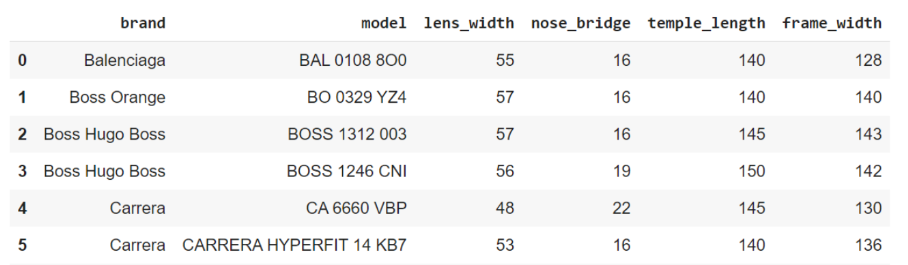

In [1]:
import html
import pandas as pd
from functools import wraps
from bs4.element import Tag
from bs4 import BeautifulSoup

## Функции парсинга

#### Вспомогательные функции

In [2]:
def capitalize_all(val : str) -> str:
  return " ".join([v.capitalize() for v in val.split()])

In [3]:
def index_of_all_or_any(val: str, words: list[str]) -> int:
  index = val.find(' '.join(words))
  if index != -1:
    return index + len(' '.join(words))
  else:
    for word in words:
      index = val.find(word)
      if index != -1:
        return index + len(word)
    return -1

In [4]:
def none_on_exception(func):
  @wraps(func)
  def wrapper(*args, **kwargs):
      try:
        res = func(*args, **kwargs)
      except:
        res = None
      return res
  return wrapper

#### Парсеры

In [39]:
@none_on_exception
def brand_parser(offer: Tag) -> str:
  return capitalize_all(html.unescape(offer.find('vendor').text))

In [40]:
@none_on_exception
def model_parser(offer: Tag) -> str:
  brand = brand_parser(offer)
  model = html.unescape(offer.find('model').text)
  index = index_of_all_or_any(model.lower(), brand.lower().split()) + 1
  return model[index:].strip().upper()

In [41]:
@none_on_exception
def lens_width_parser(offer: Tag) -> str:
  return offer.find('param', attrs={'name': 'Ширина линзы (мм)'}).text

In [42]:
@none_on_exception
def nose_bridge_parser(offer: Tag) -> str:
  return offer.find('param', attrs={'name': 'Мост (мм)'}).text

In [43]:
@none_on_exception
def temple_length_parser(offer: Tag) -> str:
  return offer.find('param', attrs={'name': 'Длина заушника (мм)'}).text

In [44]:
@none_on_exception
def frame_width_parser(offer: Tag) -> str:
  return offer.find('param', attrs={'name': 'Ширина оправы (мм)'}).text

In [45]:
def parse_data(data: str, parsers: dict, filters = ()) -> pd.DataFrame:
  res = []
  xml_data = BeautifulSoup(data, 'xml')
  offers = xml_data.find('offers').findAll('offer')
  for offer in offers:
    if all(f(offer) for f in filters):
      parsed_offer = {key: parser(offer) for key, parser in parsers.items()}
      res.append(parsed_offer)
  return pd.DataFrame(res)

#### Фильтры

In [46]:
def frame_filter(offer: Tag) -> bool:
  return 'Оправа' in offer.find('model').text

## Парсинг данных

In [47]:
base_path = '/content/drive/MyDrive/УИИ/Стажировки/NetOptic/'
file_path = base_path + 'netoptik.yml'

In [48]:
with open(file_path, 'r') as f:
  data = f.read()

In [49]:
parsers = {
  'brand': brand_parser,
  'model': model_parser,
  'lens_width': lens_width_parser,
  'nose_bridge': nose_bridge_parser,
  'temple_length': temple_length_parser,
  'frame_width': frame_width_parser
}

df_data = parse_data(data, 
                     parsers=parsers,
                     filters=[frame_filter])
df_data

,brand,model,lens_width,nose_bridge,temple_length,frame_width
0,Balenciaga,"BAL 0108, 8O0",55,16,140,128
1,Boss Orange,"BO 0329, YZ4",57,16,140,140
2,Boss Hugo Boss,"BOSS 1312, 003",57,16,145,143
3,Boss Hugo Boss,"BOSS 1246, CNI",56,19,150,142
4,Carrera,"CA 6660, VBP",48,22,145,130
...,...,...,...,...,...,...
1395,Filos,"FF1300, 04",57,18,145,134
1396,Filos,"FF1300, 05",57,18,145,134
1397,Filos,"FF1303, 03",56,18,140,138
1398,Filos,"FF1303, 01",56,18,140,138


In [50]:
df_data.to_csv(base_path + 'netoptik.csv')

## Первичный анализ

In [51]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   brand          1400 non-null   object
 1   model          1400 non-null   object
 2   lens_width     1400 non-null   object
 3   nose_bridge    1396 non-null   object
 4   temple_length  1390 non-null   object
 5   frame_width    1398 non-null   object
dtypes: object(6)
memory usage: 65.8+ KB


In [52]:
df_data['brand'].value_counts()

You's                143
Nano                 113
Fisher Price Kids     78
Youpi! Kids           46
La Stella             45
                    ... 
Kerf                   1
Missoni                1
Retro                  1
Versace                1
Grand                  1
Name: brand, Length: 153, dtype: int64

In [53]:
df_data['model'].value_counts()

911 - 21        2
6095 C1         1
MM 1202, 8XJ    1
MM 1213, NL8    1
MM 1222, OGN    1
               ..
935 - 12        1
931 - 60        1
931 - 15        1
929 - 12        1
FF1303, 07      1
Name: model, Length: 1399, dtype: int64

In [56]:
df_data[df_data.temple_length.isna()]

,brand,model,lens_width,nose_bridge,temple_length,frame_width
86,Pensne,PO-S,38,20,None,110
117,Seeoo,"LIGHT DARCK BLACK (+2,0;+2,5)",38,16,None,
118,Seeoo,"LIGHT DARK BLUE (+1,5;+2,0;+2,5;+3,0 )",38,16,None,
168,Pensne,"GLODIATR BLACK (+1,0;+1,5;+2,0;+2,5)",42,None,None,None
169,Pensne,"GLODIATR LIGHT BLACK (+1,0;+2,0;+2,5)",41,16,None,102
185,Seeoo,"LIGHT DARCK BROWN (+1,5;+2,5)",37,None,None,None
339,Pensne,PK-Z,41,None,None,99
341,Pensne,PK-S,41,None,None,100
572,Pensne,PO-S (B),40,16,None,92
850,Pensne,"A42 (+1,0;+1,5)",35,13,None,90


In [55]:
df_data[df_data.nose_bridge.isna()]

,brand,model,lens_width,nose_bridge,temple_length,frame_width
168,Pensne,"GLODIATR BLACK (+1,0;+1,5;+2,0;+2,5)",42,None,None,None
185,Seeoo,"LIGHT DARCK BROWN (+1,5;+2,5)",37,None,None,None
339,Pensne,PK-Z,41,None,None,99
341,Pensne,PK-S,41,None,None,100


In [57]:
df_data[df_data.frame_width.isna()]

,brand,model,lens_width,nose_bridge,temple_length,frame_width
168,Pensne,"GLODIATR BLACK (+1,0;+1,5;+2,0;+2,5)",42,None,None,None
185,Seeoo,"LIGHT DARCK BROWN (+1,5;+2,5)",37,None,None,None
